In [2]:
import torch

import torch.nn as nn
import torch.nn.functional as F

class ImageSimilarityModel(nn.Module):
    def __init__(self):
        super(ImageSimilarityModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Setting up the Fully Connected Layers
        # Define the fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(32*32*32, 512)
        )
        self.mha = nn.MultiheadAttention(embed_dim=512, num_heads=2)
        self.final=nn.Sequential(nn.Linear(512,1),nn.Sigmoid())
        self.w1=nn.Linear(1000,1000)
        self.w2=nn.Linear(1000,1000)
        self.w3=nn.Linear(1000,1000)
    
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
    # Pass the inputs through the pre-trained ResNet18 model to get 512-dimensional embeddings
        query = self.forward_once(input1)
        key = self.forward_once(input2)
        print(key.shape)
        # query=self.w1(query)
        # value=self.w3(key)
        # key=self.w2(key)

        # Pass the query, key, and value through the Multi-Head Attention layer to get the similarity score
        attn_output, attn_output_weights = self.mha(query, key, key)

        attn_output = self.final(attn_output)

        similarity_score = attn_output.squeeze(1)
        return similarity_score

In [2]:
a=torch.rand(1000,3,256,256)
b=torch.rand(1000,3,256,256)
model=ImageSimilarityModel()
model(a,b).shape

torch.Size([1000, 512])


torch.Size([1000])

In [28]:
import torch
import numpy as np
import torch.nn as nn
from img2vec_pytorch import Img2Vec
import torch.nn.functional as F
from torchmetrics.functional.pairwise import pairwise_euclidean_distance
import torchmetrics
import lightning as l
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
from PIL import Image
import pandas as pd
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)[:4000]
        self.transform = transform
        self.extract=Img2Vec()

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name1 = self.data.iloc[idx, 0]
        img_name2 = self.data.iloc[idx, 1]

        image1 = Image.open(img_name1).convert("RGB")
        image2 = Image.open(img_name2).convert("RGB")

        # Applying Canny edge detection using OpenCV
        image_cv1 = cv2.cvtColor(np.array(image1), cv2.COLOR_RGB2BGR)
        edges1 = cv2.Canny(image_cv1, 100, 200)
        image_cv2 = cv2.cvtColor(np.array(image2), cv2.COLOR_RGB2BGR)
        edges2 = cv2.Canny(image_cv2, 100, 200)

        # Convert images to RGB
        image1 = Image.fromarray(cv2.cvtColor(edges1, cv2.COLOR_GRAY2RGB))
        image2 = Image.fromarray(cv2.cvtColor(edges2, cv2.COLOR_GRAY2RGB))

        extracted_features1 =self.extract.get_vec(image1)
        extracted_features2 =self.extract.get_vec(image2)
        extracted_features1=torch.from_numpy(extracted_features1)
        extracted_features2=torch.from_numpy(extracted_features2)
        print(extracted_features1.shape,extracted_features2.shape)
        print(extracted_features1.dtype,extracted_features2.dtype)

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        label = int(self.data.iloc[idx, -1])

        return extracted_features1, extracted_features1, label

class CustomDataModule1(l.LightningDataModule):
    def __init__(self,  transform=None, batch_size=64):
        super().__init__()
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = CustomDataset("data/CEDAR_train.csv", transform=self.transform)
        self.val_dataset = CustomDataset("data/CEDAR_val.csv", transform=self.transform)
        self.test_dataset = CustomDataset("data/CEDAR_test.csv", transform=self.transform)
        

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,num_workers=7)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,num_workers=7)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,num_workers=7)

class LightningModel1(l.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        # Save settings and hyperparameters to the log directory
        # but skip the model parameters
        self.save_hyperparameters(ignore=['model'])

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        # self.val_auc=torchmetrics.ROC(task="binary")
        self.val_recall=torchmetrics.Recall(task="binary")
        self.val_precision=torchmetrics.Precision(task="binary")
        # self.test_auc=torchmetrics.ROC(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_recall=torchmetrics.Recall(task="binary")
        self.test_precision=torchmetrics.Precision(task="binary")

    def forward(self, x,y):
        return self.model(x,y)

    def _shared_step(self, batch):
        input,original, true_labels = batch
        logits= self(input,original)
        loss = F.binary_cross_entropy(logits, true_labels.float())
        predicted_labels = (logits > 0.5).float()
        # print(true_labels.shape,predicted_labels.shape)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step= True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True,on_step=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True,on_step=True)
        self.val_recall(predicted_labels, true_labels)
        self.log("val_recall", self.val_recall, prog_bar=True,on_step=True)
        self.val_precision(predicted_labels, true_labels)
        self.log("val_precision", self.val_precision, prog_bar=True,on_step=True)

    def test_step(self, batch, batch_idx):
        _, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)
        self.test_recall(predicted_labels, true_labels)
        self.log("test_recall", self.test_recall)
        self.test_precision(predicted_labels, true_labels)
        self.log("test_precision", self.test_precision)
    

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [29]:
import torchvision.transforms as transforms
transform = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor()])
m=CustomDataset("data/CEDAR_train.csv")

c:\Users\ASUS\Desktop\signature verification similarity\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\Desktop\signature verification similarity\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
i,j,k=m[0]

torch.Size([512]) torch.Size([512])
torch.float32 torch.float32


In [31]:
i.shape

torch.Size([512])

In [32]:
k

0

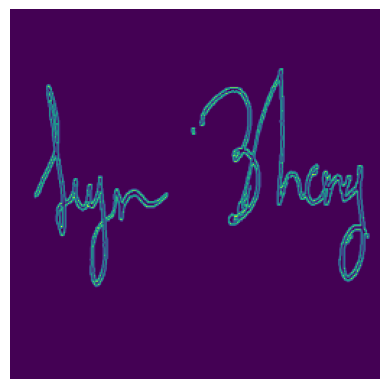

In [10]:
import matplotlib.pyplot as plt
import torchvision


# Display the image using matplotlib
plt.imshow(i[0])

plt.axis('off')  # Turn off axis
plt.show()


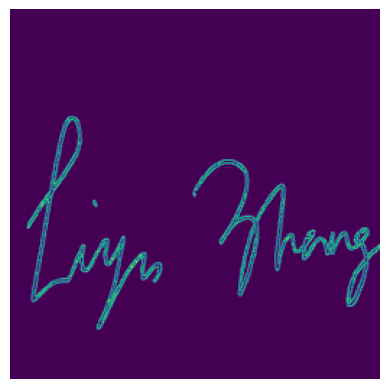

In [11]:
plt.imshow(j[0])
plt.axis('off')  # Turn off axis
plt.show()

In [4]:
import lightning as l
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger
from torchvision import transforms

torch.manual_seed(123)

transform = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor(),
transforms.Lambda(lambda img: img / 255.0)])

dm = CustomDataModule1(batch_size=64,transform=transform)

pytorch_model = ImageSimilarityModel()

lightning_model = LightningModel1(model=pytorch_model, learning_rate=0.00005)


checkpoint_callback = ModelCheckpoint(
    dirpath="./models",filename="best_model1",
    save_top_k=1,monitor="val_loss", mode="min"
)
early_stopping_callback = EarlyStopping(
    monitor="val_acc", patience=3, verbose=True, mode="max"
)

trainer = l.Trainer(callbacks=[checkpoint_callback,early_stopping_callback],
    max_epochs=6,
    logger=CSVLogger(save_dir="logs/", name="model1_logs"),
    accelerator="cpu",
    devices="auto",
)

trainer.fit(model=lightning_model, datamodule=dm)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\ASUS\Desktop\signature verification similarity\.venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\ASUS\Desktop\signature verification similarity\models exists and is not empty.

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | ImageSimilarityModel | 20.8 M
1 | train_acc      | BinaryAccuracy       | 0     
2 | val_acc        | BinaryAccuracy       | 0     
3 | val_recall     | BinaryRecall         | 0     
4 | val_precision  | BinaryPrecision      | 0     
5 | test_acc       | BinaryAccuracy       | 0     
6 | test_recall    | BinaryRecall         | 0     
7 | test_precision | BinaryPrecision      | 0     
--------------------------------------------------------
20.8 M    Trainable params
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\ASUS\Desktop\signature verification similarity\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
